# Predict Sale Price of Bulldozers using Machine Learning

In this notebook, we will build a project that has a goal of predicting the sale price of bulldozers using Machine Learning.

Since we're trying to predict a number, this kind of problem is known as a regression problem.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition.](https://www.kaggle.com/c/bluebook-for-bulldozers/overview)

The techniques used in here have been inspired and adapted from the [fast.ai machine learning course](https://course18.fast.ai/ml).

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can know it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale


## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
# Import data analysis tools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
# Import Train and Validation sets

df = pd.read_csv('./data/TrainAndValid.csv', low_memory=False)
df.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246    66000.0     999089     3157         121           3.0      2004   
1  1139248    57000.0     117657       77         121           3.0      1996   
2  1139249    10000.0     434808     7009         121           3.0      2001   
3  1139251    38500.0    1026470      332         121           3.0      2001   
4  1139253    11000.0    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand         saledate  ...  \
0                      68.0       Low  11/16/2006 0:00  ...   
1                    4640.0       Low   3/26/2004 0:00  ...   
2                    2838.0      High   2/26/2004 0:00  ...   
3                    3486.0      High   5/19/2011 0:00  ...   
4                     722.0    Medium   7/23/2009 0:00  ...   

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN          NaN   NaN             NaN          NaN   
1                     NaN          NaN   NaN             NaN          NaN   
2                     NaN          NaN   NaN             NaN          NaN   
3                     NaN          NaN   NaN             NaN          NaN   
4                     NaN          NaN   NaN             NaN          NaN   

  Backhoe_Mounting Blade_Type Travel_Controls Differential_Type  \
0              NaN        NaN             NaN          Standard   
1              NaN        NaN             NaN          Standard   
2              NaN        NaN             NaN               NaN   
3              NaN        NaN             NaN               NaN   
4              NaN        NaN             NaN               NaN   

  Steering_Controls  
0      Conventional  
1      Conventional  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 53 columns]

### Exploring the data
We have to get more information on the data, hence we perform these steps so that we can use this data more accurately in modelling.

In [3]:
# first lets get some basic info about the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# lets have a look at all the column names
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [5]:
# finding out missing values in the data
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

<AxesSubplot:ylabel='Frequency'>

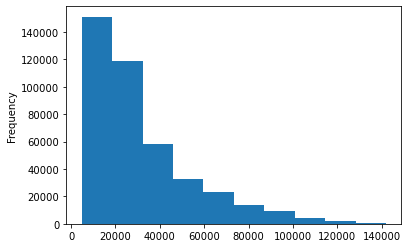

In [6]:
# lets visualize the distribution of 'SalePrice' using a histogram.
df['SalePrice'].plot.hist()

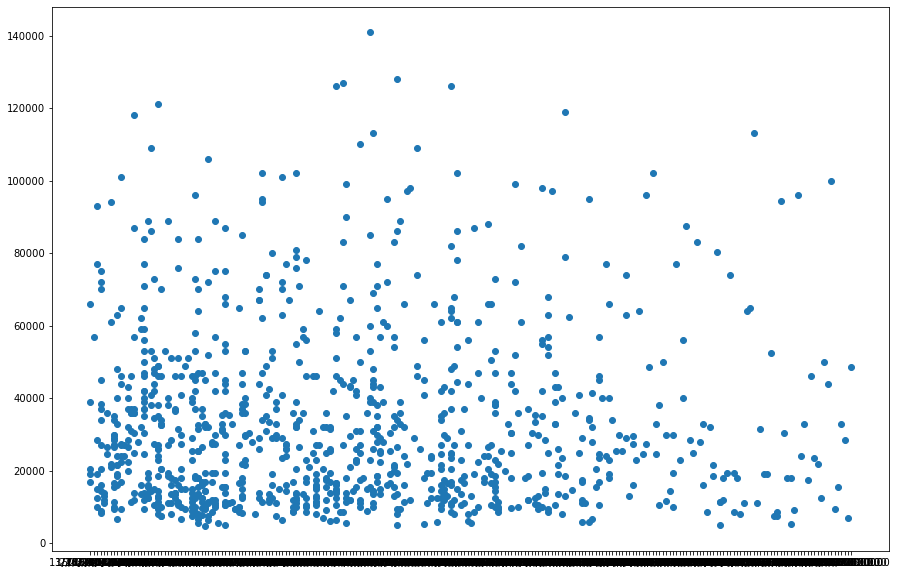

In [7]:
# lets try to visualize the 'saledate' and 'SalePrice' on a scatter plot
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])
plt.show()

In [8]:
# lets check the data type of 'saledate' column.
df['saledate'].dtype

dtype('O')

The 'saledate' column has datatype 'object' which is basically a string value so the visualization is not accurate. Thus, the data in 'saledate' column should be converted into datetime as it contains time series data.

### Parsing Dates
Since the 'saledate' column has  time series data, it should be represented as datetime datatype rather than object.

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by Parsing Dates i.e. letting pandas know which columns have dates in it using the `parse_dates` parameter.

In [9]:
# importing data again with parse dates parameter so it can parse dates.
df = pd.read_csv('./data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

The `parse_dates` parameter Let's convert col3, that has the string content, to a datetime datatype. If you don't use parse_dates in the read_csv call, col3 will be represented as an object.

Now that we have parsed the dates, we should be able to represent the data as datetime object

In [10]:
# lets check the datatype of 'saledate column' after parsing the dates.
df['saledate'].dtype

dtype('<M8[ns]')

Now that we have parsed the time series data as a datetime object, we should be able to properly visualise the 'saledate' and 'SalePrice' columns on a scatter plot.

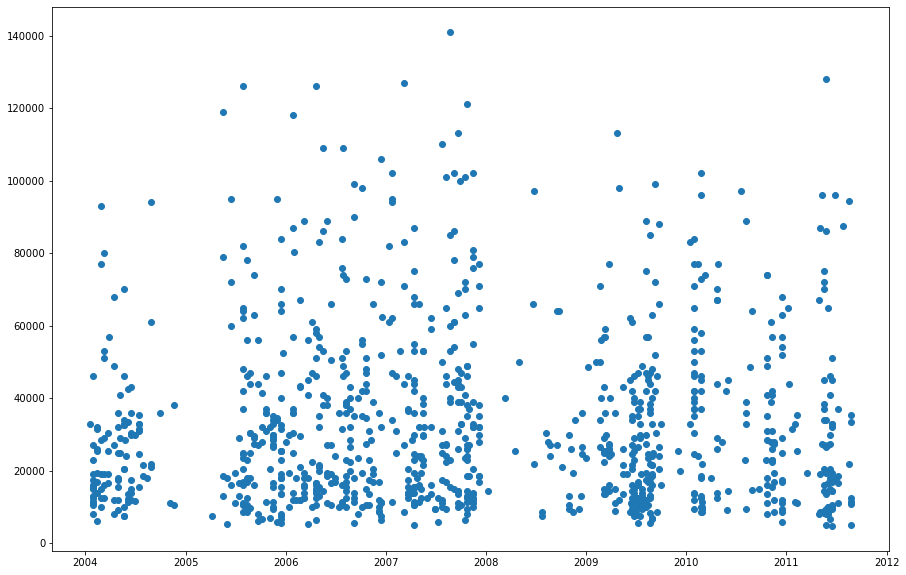

In [11]:
# lets try to visualize the 'saledate' and 'SalePrice' on a scatter plot after parsing the dates.
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])
plt.show()

This visualization is accurate as it has datetime object and has correctly plotted the date of sales.

When working with time series data , it's a good practice to sort it by date.
Now, we will sort the data by 'saledate' as it will be easy for us to further explore the data.

In [12]:
# view 'saledate column'
df['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [13]:
# Sort data by saledate
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df['saledate']

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

### Make a copy of the original DataFrame
We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [14]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for `saledate` column.
The datetime datatype gives us attributes that can be used for further exploration of the datetime datatype in our case it is the `saledate` column.

In [15]:
# Adding more columns to the data so that the saledate column data can be enriched.
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [16]:
# view the columns added to the data.
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
205615  1646770     9500.0    1126363     8434         132          18.0   
274835  1821514    14000.0    1194089    10150         132          99.0   
141296  1505138    50000.0    1473654     4139         132          99.0   
212552  1671174    16000.0    1327630     8591         132          99.0   
62755   1329056    22000.0    1336053     4089         132          99.0   

        YearMade  MachineHoursCurrentMeter UsageBand   saledate  ...  \
205615      1974                       NaN       NaN 1989-01-17  ...   
274835      1980                       NaN       NaN 1989-01-31  ...   
141296      1978                       NaN       NaN 1989-01-31  ...   
212552      1980                       NaN       NaN 1989-01-31  ...   
62755       1984                       NaN       NaN 1989-01-31  ...   

           Backhoe_Mounting Blade_Type      Travel_Controls Differential_Type  \
205615  None or Unspecified   Straight  None or Unspecified               NaN   
274835                  NaN        NaN                  NaN          Standard   
141296  None or Unspecified   Straight  None or Unspecified               NaN   
212552                  NaN        NaN                  NaN          Standard   
62755   None or Unspecified        PAT                Lever               NaN   

       Steering_Controls saleYear saleMonth saleDay saleDayOfWeek  \
205615               NaN     1989         1      17             1   
274835      Conventional     1989         1      31             1   
141296               NaN     1989         1      31             1   
212552      Conventional     1989         1      31             1   
62755                NaN     1989         1      31             1   

       saleDayOfYear  
205615            17  
274835            31  
141296            31  
212552            31  
62755             31  

[5 rows x 58 columns]

Now we've enriched our DataFrame with date time features, we can remove 'saledate'

In [17]:
# dropping the saledate column
df_tmp.drop('saledate', axis=1, inplace=True)
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
205615  1646770     9500.0    1126363     8434         132          18.0   
274835  1821514    14000.0    1194089    10150         132          99.0   
141296  1505138    50000.0    1473654     4139         132          99.0   
212552  1671174    16000.0    1327630     8591         132          99.0   
62755   1329056    22000.0    1336053     4089         132          99.0   

        YearMade  MachineHoursCurrentMeter UsageBand fiModelDesc  ...  \
205615      1974                       NaN       NaN        TD20  ...   
274835      1980                       NaN       NaN         A66  ...   
141296      1978                       NaN       NaN         D7G  ...   
212552      1980                       NaN       NaN         A62  ...   
62755       1984                       NaN       NaN         D3B  ...   

           Backhoe_Mounting Blade_Type      Travel_Controls Differential_Type  \
205615  None or Unspecified   Straight  None or Unspecified               NaN   
274835                  NaN        NaN                  NaN          Standard   
141296  None or Unspecified   Straight  None or Unspecified               NaN   
212552                  NaN        NaN                  NaN          Standard   
62755   None or Unspecified        PAT                Lever               NaN   

       Steering_Controls saleYear saleMonth saleDay saleDayOfWeek  \
205615               NaN     1989         1      17             1   
274835      Conventional     1989         1      31             1   
141296               NaN     1989         1      31             1   
212552      Conventional     1989         1      31             1   
62755                NaN     1989         1      31             1   

       saleDayOfYear  
205615            17  
274835            31  
141296            31  
212552            31  
62755             31  

[5 rows x 57 columns]

Do some further EDA about the data

In [18]:
# Exploring the 'state' column of the data and checking the values of the column.
df_tmp['state'].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

More EDA is always good as it lets us know more about the data whic can come in handy while modelling.

## Modelling
Let's try to do some model driven EDA.
Model Driven EDA refers to a practice where we try to explore the data based on the model that we build. This includes improvement of the model parameters or finding corelations between the data.

In [19]:
# First lets build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [20]:
# Split data into X and y.
X = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

This is the time to fit model with data but it is not possible because not all the columns are in numeric form. Also there is missing data into the columns.

In [21]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

The data we have is not consistant, i.e. the data contains null or missing values therefore we need to treat the data first before fitting the data into the model.

First we need to treat the columns that do not have numeric features into categorical features by converting them into pandas categories.
We can check the different datatypes compatible with pandas here:
https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

First we need to find out the columns that contain strings.

In [22]:
#finding columns with string values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
# converting all the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [24]:
# now we check the datatype of all the columns
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [25]:
df_tmp['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [26]:
df_tmp['state'].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

We can see that all the data that was in the form of strings are now converted into categorical values, i.e. numbers.

We still have to treat the missing data.
So first we need to find the amount of missing data we currently have.

In [27]:
# check how much missing data we are dealing with
df_tmp.isna().sum()/len(df_tmp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

Now we can start processing the data, i.e. filling the missing values, but before that it is a good practice to save the preprocessed data in a `.csv` file.

In [28]:
# saving preprocessed data to csv file
df_tmp.to_csv('./data/TrainAndValid_tmp.csv', index=False)

In [29]:
# importing the preprocessed data form a csv file
df_tmp = pd.read_csv('./data/TrainAndValid_tmp.csv', low_memory=False)
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter UsageBand fiModelDesc  ...     Backhoe_Mounting  \
0                       NaN       NaN        TD20  ...  None or Unspecified   
1                       NaN       NaN         A66  ...                  NaN   
2                       NaN       NaN         D7G  ...  None or Unspecified   
3                       NaN       NaN         A62  ...                  NaN   
4                       NaN       NaN         D3B  ...  None or Unspecified   

  Blade_Type      Travel_Controls Differential_Type Steering_Controls  \
0   Straight  None or Unspecified               NaN               NaN   
1        NaN                  NaN          Standard      Conventional   
2   Straight  None or Unspecified               NaN               NaN   
3        NaN                  NaN          Standard      Conventional   
4        PAT                Lever               NaN               NaN   

  saleYear saleMonth saleDay saleDayOfWeek saleDayOfYear  
0     1989         1      17             1            17  
1     1989         1      31             1            31  
2     1989         1      31             1            31  
3     1989         1      31             1            31  
4     1989         1      31             1            31  

[5 rows x 57 columns]

### Filling missing values.
Now let's begin to process the data by first filling out the missing values. First we check the data for missing values.

In [30]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

#### Dealing with missing numeric values.
First we will deal with the numeric missing values as they will be relatively easy to deal with.  So to deal with numeric missing values, we need to determine what numeric data is missing.

In [31]:
# finding numeric values that are missing.

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


Now that we have concluded that the `auctioneerID` column and
`MachineHoursCurrentMeter` column has missing numeric values, we can now fill the missing values with the median.

Note: Median is used because it is more robust and less sensitive to extreme outliers.
For more details refer:
https://statistics.laerd.com/statistical-guides/measures-central-tendency-mean-mode-median.php

In [32]:
# Fill missing values with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add binary column which tells us if the data was missing
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing values with median.
            df_tmp[label] = content.fillna(content.median())

In [33]:
#check the dataframe if missing numeric values are filled
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter UsageBand fiModelDesc  ...      Travel_Controls  \
0                       0.0       NaN        TD20  ...  None or Unspecified   
1                       0.0       NaN         A66  ...                  NaN   
2                       0.0       NaN         D7G  ...  None or Unspecified   
3                       0.0       NaN         A62  ...                  NaN   
4                       0.0       NaN         D3B  ...                Lever   

  Differential_Type Steering_Controls saleYear saleMonth saleDay  \
0               NaN               NaN     1989         1      17   
1          Standard      Conventional     1989         1      31   
2               NaN               NaN     1989         1      31   
3          Standard      Conventional     1989         1      31   
4               NaN               NaN     1989         1      31   

  saleDayOfWeek saleDayOfYear auctioneerID_is_missing  \
0             1            17                   False   
1             1            31                   False   
2             1            31                   False   
3             1            31                   False   
4             1            31                   False   

  MachineHoursCurrentMeter_is_missing  
0                                True  
1                                True  
2                                True  
3                                True  
4                                True  

[5 rows x 59 columns]

In [34]:
# Check to see how many examples were missing
df_tmp['auctioneerID_is_missing'].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [35]:
df_tmp['MachineHoursCurrentMeter_is_missing'].value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [36]:
# now we check if there are any more missing numeric values left.
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
print('no missing numeric values')

no missing numeric values


In [37]:
# check if we filled the columns that we were supposed to, i.e. auctioneerID and MachineHoursCurrentMeter
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Dealing with missing Categorical values.

Now that we have filled all the missing numerical values, we need to deal with the categorical values that are missing. First we need to find all the categorical columns that have missing data.

In [38]:
# finding categorical values that are missing.

for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        if pd.isnull(content).sum():
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


Now that we know the columns that have categorical values, to deal with the missing values we need to first convert them to numeric values. Then we can fill the missing values.

In [39]:
# Turn categorical variables into numbers and fill missing values

for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        # Add binary column which tells us if the data was missing
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

Here we add +1 to the codes as pandas assigns Categorical code of -1 to null values, thus we do not have to deal with negative values as such.
For more about pandas Categorical function refer:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html

In [40]:
#check the dataframe if missing categorical values are filled
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0                       0.0          0         4593  ...   
1                       0.0          0         1820  ...   
2                       0.0          0         2348  ...   
3                       0.0          0         1819  ...   
4                       0.0          0         2119  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 103 columns]

In [41]:
# checking the shape of the dataset
df_tmp.shape

(412698, 103)

In [42]:
# checking if dataset has any missing values left to filled
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now, the data is converted into numerical data and the columns that contained missing values are filled and there are no missing values in our data. But the dataframe now contains `103` columns since binary columns are added to the columns containing missing data.

Now, that we are ready to start building a machine learning model, we will now have to again split the data into Feature and Target set i.e. `X` and `y`

In [43]:
# Let's build a machine learning model from scratch
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

In [44]:
# splitting data into X and y

X = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

In [45]:
# Fit the model with the data
#model.fit(X,y)

In [46]:
# scoring the model with the same data
#model.score(X,y)

We can see that our model has scored very high, but this metric is not much reliable as we have scored it on the training dataset itself. If we need to get accurate metrics of the model, we need to evaluate it using the Test dataset.

### Splitting Data into Training and Validation Sets
Before testing the model with the test dataset, we need to test and validate it using the validation set. Since the validation set is imported beforehand with the trainig data, we need to split it up into Training and Validation Sets.

In [47]:
df_tmp.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0                       0.0          0         4593  ...   
1                       0.0          0         1820  ...   
2                       0.0          0         2348  ...   
3                       0.0          0         1819  ...   
4                       0.0          0         2119  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 103 columns]

We will split the data based on the date of the data. Since our data is sorted by time, it should be easy for us to do so.

**The training set**, contains data through the end of 2011.

**The validation set**, contains data from January 1, 2012 - April 30, 2012.

In [48]:
# splitting the dataset into train and validation set
df_train = df_tmp[df_tmp['saleYear'] != 2012]
df_train.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770     9500.0    1126363     8434         132          18.0      1974   
1  1821514    14000.0    1194089    10150         132          99.0      1980   
2  1505138    50000.0    1473654     4139         132          99.0      1978   
3  1671174    16000.0    1327630     8591         132          99.0      1980   
4  1329056    22000.0    1336053     4089         132          99.0      1984   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0                       0.0          0         4593  ...   
1                       0.0          0         1820  ...   
2                       0.0          0         2348  ...   
3                       0.0          0         1819  ...   
4                       0.0          0         2119  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                                True                     True   
3                                True                     True   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2              True                        True                     True   
3              True                        True                     True   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                        False                  False   
1                         True                   True   
2                        False                  False   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                       False                          True   
1                        True                         False   
2                       False                          True   
3                        True                         False   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                         False  
4                          True  

[5 rows x 103 columns]

In [49]:
df_val = df_tmp[df_tmp['saleYear'] == 2012]
df_val.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
401125  4449186    46173.2    2318824    26964         173          99.0   
401126  1222855    66000.0     531393    23926         121           3.0   
401127  6258613    26800.0    1810917    13260         149          99.0   
401128  6282680    42100.0    1543404     1830         149          99.0   
401129  6282759    62100.0    1863077    11390         149          99.0   

        YearMade  MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
401125      1996                       0.0          0         2269  ...   
401126      1000                    8145.0          2           85  ...   
401127      2000                      24.0          2         1115  ...   
401128      2004                    4373.0          3           64  ...   
401129      2006                    3467.0          3          139  ...   

        Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
401125                                True                     True   
401126                                True                     True   
401127                                True                     True   
401128                               False                    False   
401129                               False                    False   

        Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
401125              True                        True                     True   
401126              True                        True                     True   
401127              True                        True                     True   
401128             False                       False                    False   
401129             False                       False                    False   

        Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
401125                        False                  False   
401126                         True                   True   
401127                         True                   True   
401128                         True                   True   
401129                         True                   True   

        Travel_Controls_is_missing  Differential_Type_is_missing  \
401125                       False                          True   
401126                        True                          True   
401127                        True                          True   
401128                        True                          True   
401129                        True                          True   

        Steering_Controls_is_missing  
401125                          True  
401126                          True  
401127                          True  
401128                          True  
401129                          True  

[5 rows x 103 columns]

In [50]:
#checking the lengths of both the datasets
len(df_train), len(df_val)

(401125, 11573)

Now that we have split the data into training and validation set, to fit it into a model, we further need to split both the sets into Feature and Target `X` and `y` sets.

In [51]:
# Splitting both the sets into Feature and Target set i.e. X and y
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']

X_val = df_val.drop('SalePrice', axis=1)
y_val = df_val['SalePrice']

In [52]:
# check shapes of the sets

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation metric for the model

In this project, we will use the RMSLE(Root Mean Square Log Error) to evaluate the model that we build. It is a good practice to score the model with more than one metric. But for the course of this project, we will work with RMSLE.

Read more about Evaluation Metrics : https://scikit-learn.org/stable/modules/model_evaluation.htmld

We will be building an evaluation function so that the function makes it easy to test and experiment on different models and data.

In [53]:
# create evaluation function

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Evaluation function for Root Mean Squared Log Error

def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [54]:
# Function to evaluate model on different levels

def show_scores(model):
    """
    This calculates MAE, RSMLE and R^2 scores for training and validation sets on the model that is passed
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_val, val_preds)}
    return scores 

### Testing the model (to tune hyperparameters)
So lets tune the hyperparameters on a subset of the data that we have, Since training the model with such large data takes a huge amount of time, to reduce the time taken between the experiments we first need to make a subset of the data we have.

We can make a subset of the data by slicing the dataset, but this method is not much versatile therfore we will use `max_samples` function that comes with RandomForestRegressor to do so.

In [55]:
# instantiate the model with max samples = 10000
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [56]:
%%time
model.fit(X_train, y_train)

Wall time: 8.07 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

This takes much less time than the model that we trained before as this takes only 10000 samples of data. This makes it easy to tune the model as the times between experiments will be less.

Now, we can evaluate our model with the custom evaluation metric function that we created.

In [57]:
# calling the evaluation function
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter Tuning with RandomizedSearchCV

Now that we have tested and evaluated the model, it is time to tune the hyperparameters of the model so that the score of the model can be improved. We will use RandomizedSearchCV to tune the hyperparameters for the model and try to improve our model.

In [58]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.0s finished


Wall time: 49.7 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [59]:
# finding the best parameters for the model
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 12,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 10}

In [60]:
# evaluating the model
show_scores(rs_model)

{'Training MAE': 9231.098053782325,
 'Valid MAE': 10859.56327776268,
 'Training RMSLE': 0.4033894883252904,
 'Valid RMSLE': 0.4281161729917359,
 'Training R^2': 0.6640126839561024,
 'Valid R^2': 0.6638282807238302}

### Training the model with hyperprameters
These were found after 100 iterations of RandomizedSearchCV.

In [61]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 53.2 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [62]:
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.2452416398953833,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

As we can see that this has improved the score of our model, we can tune the model more as required but for now we use this model for further test purpose.

### Making predictions on the test data.
Now, as the model is ready, we need to test it on the test dataset which will then give us a fair idea about how the model is performing. First we need to import the test data and make predictions on it.

In [63]:
# Import the test data
df_test = pd.read_csv('./data/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  ...  \
0                    3688.0       Low 2012-05-03        580G  ...   
1                   28555.0      High 2012-05-10         936  ...   
2                    6038.0    Medium 2012-05-10    EC210BLC  ...   
3                    8940.0      High 2012-05-10       330CL  ...   
4                    2286.0       Low 2012-05-10        650K  ...   

  Undercarriage_Pad_Width         Stick_Length   Thumb      Pattern_Changer  \
0                     NaN                  NaN     NaN                  NaN   
1                     NaN                  NaN     NaN                  NaN   
2     None or Unspecified                9' 6"  Manual  None or Unspecified   
3     None or Unspecified  None or Unspecified  Manual                  Yes   
4                     NaN                  NaN     NaN                  NaN   

  Grouser_Type     Backhoe_Mounting Blade_Type      Travel_Controls  \
0          NaN                  NaN        NaN                  NaN   
1          NaN                  NaN        NaN                  NaN   
2       Double                  NaN        NaN                  NaN   
3       Triple                  NaN        NaN                  NaN   
4          NaN  None or Unspecified        PAT  None or Unspecified   

  Differential_Type Steering_Controls  
0               NaN               NaN  
1          Standard      Conventional  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN  

[5 rows x 52 columns]

Now once we have imported the test data, we can see that the data is not in the same format as the training data. 

### Preprocessing the Test Data.
Now, to make predictions on the test data, we need to manipulate it the same way as the we did with the training data.
Now to preprocess the data we can process it the same way as the training data, but if we do it like that, we will have to do it manually each time we import a new dataset. So rather we can create a function that will do it which can be easily reused to treat data that we import in the future.

In [64]:
# Make a function that treas the raw data

def preprocess_data(df):
    """
     Performs transformations on dataframe and returns transformed dataframe.
    """
    
    # saledata broken in different columns
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    # dropping saledate column
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill missing values with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add binary column which tells us if the data was missing
                df[label+'_is_missing'] = pd.isnull(content)
                # Fill missing values with median.
                df[label] = content.fillna(content.median())
        # Filled categorical missing data and turn categories into numbers
        if pd.api.types.is_object_dtype(content):
            # Add binary column which tells us if the data was missing
            df[label+'_is_missing'] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
            
    return df

Now we pass the test data to the function `preprocess_data()` so that we can see if it has treated the data correctly

In [65]:
# treat the data using the function
df_test = preprocess_data(df_test)
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Undercarriage_Pad_Width_is_missing  Stick_Length_is_missing  \
0                                True                     True   
1                                True                     True   
2                               False                    False   
3                               False                    False   
4                                True                     True   

   Thumb_is_missing  Pattern_Changer_is_missing  Grouser_Type_is_missing  \
0              True                        True                     True   
1              True                        True                     True   
2             False                       False                    False   
3             False                       False                    False   
4              True                        True                     True   

   Backhoe_Mounting_is_missing  Blade_Type_is_missing  \
0                         True                   True   
1                         True                   True   
2                         True                   True   
3                         True                   True   
4                        False                  False   

   Travel_Controls_is_missing  Differential_Type_is_missing  \
0                        True                          True   
1                        True                         False   
2                        True                          True   
3                        True                          True   
4                       False                          True   

   Steering_Controls_is_missing  
0                          True  
1                         False  
2                          True  
3                          True  
4                          True  

[5 rows x 101 columns]

In [66]:
df_test.shape

(12457, 101)

The training data had shape of `(401125, 102)` therefore our test data is missing a column. To find out which column is missing, we can use columns as python `set`.

In [67]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

This means that the `auctioneerID_is_missing` column is missing. The reason of the column missing is that there were no null values in the column therefore the function did not add `auctioneerID_is_missing` column. To solve this problem we need to add the `auctioneerID_is_missing` column manually with all values as `False`.

In [68]:
# manually adding column
df_test['auctioneerID_is_missing'] = False
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                    3688.0          2          499          180  ...   
1                   28555.0          1          831          292  ...   
2                    6038.0          3         1177          404  ...   
3                    8940.0          1          287          113  ...   
4                    2286.0          2          566          196  ...   

   Stick_Length_is_missing  Thumb_is_missing  Pattern_Changer_is_missing  \
0                     True              True                        True   
1                     True              True                        True   
2                    False             False                       False   
3                    False             False                       False   
4                     True              True                        True   

   Grouser_Type_is_missing  Backhoe_Mounting_is_missing  \
0                     True                         True   
1                     True                         True   
2                    False                         True   
3                    False                         True   
4                     True                        False   

   Blade_Type_is_missing  Travel_Controls_is_missing  \
0                   True                        True   
1                   True                        True   
2                   True                        True   
3                   True                        True   
4                  False                       False   

   Differential_Type_is_missing  Steering_Controls_is_missing  \
0                          True                          True   
1                         False                         False   
2                          True                          True   
3                          True                          True   
4                          True                          True   

   auctioneerID_is_missing  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  

[5 rows x 102 columns]

Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [69]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [70]:
# Making predictions in proper format
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

SalesID    SalesPrice
0      1227829  20614.367809
1      1227844  19897.801707
2      1227847  44852.219594
3      1227848  68346.325323
4      1227863  39487.349708
...        ...           ...
12452  6643171  46466.092910
12453  6643173  17500.493352
12454  6643184  14296.986205
12455  6643186  22164.857577
12456  6643196  31683.800634

[12457 rows x 2 columns]

### Export the predictions to file
Now as we have done the predictions with our model, we can store it to a `.csv` file.

In [71]:
# Export prediction data
df_preds.to_csv("./data/test_predictions.csv", index=False)

### Feature Importance
Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

Feature importance scores can be calculated for problems that involve predicting a numerical value, called regression, and those problems that involve predicting a class label, called classification.

The scores are useful and can be used in a range of situations in a predictive modeling problem, such as:

Better understanding the data.
Better understanding a model.
Reducing the number of input features.
Feature importance scores can provide insight into the dataset. The relative scores can highlight which features may be most relevant to the target, and the converse, which features are the least relevant. This may be interpreted by a domain expert and could be used as the basis for gathering more or different data.

Feature importance scores can provide insight into the model. Most importance scores are calculated by a predictive model that has been fit on the dataset. Inspecting the importance score provides insight into that specific model and which features are the most important and least important to the model when making a prediction. This is a type of model interpretation that can be performed for those models that support it.

Feature importance can be used to improve a predictive model. This can be achieved by using the importance scores to select those features to delete (lowest scores) or those features to keep (highest scores). This is a type of feature selection and can simplify the problem that is being modeled, speed up the modeling process (deleting features is called dimensionality reduction), and in some cases, improve the performance of the model.

Feature importance scores can be fed to a wrapper model, such as the SelectFromModel class, to perform feature selection.

There are many ways to calculate feature importance scores and many models that can be used for this purpose.

In [72]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [73]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

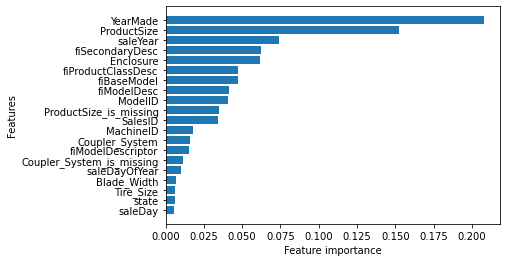

In [74]:
plot_features(X_train.columns, ideal_model.feature_importances_)

So, the as the graph depicts, the features that are most important to the price is `YearMade`.

